In [1]:
import pandas as pd
from tqdm import tqdm
from utils.data import pad_and_concat
import os
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import pytorch_lightning as pl
import torch
from torch import nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
%load_ext tensorboard
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
class GetFullDF:
    def __init__(self):
        self.df = None
    def __call__(self):
        if self.df is None:
            df = pd.concat([
                pd.read_csv('/scratch/mcinerney.de/metaicl/eval_results/results_gpt2meta6/results_commonsense_qa_1.csv'),
                pd.read_csv('/scratch/mcinerney.de/metaicl/eval_results/results_gpt2meta6/results_commonsense_qa_2.csv'),
                pd.read_csv('/scratch/mcinerney.de/metaicl/eval_results/results_gpt2meta6/results_commonsense_qa_3.csv'),
                pd.read_csv('/scratch/mcinerney.de/metaicl/eval_results/results_gpt2meta6/results_commonsense_qa_4.csv'),
                pd.read_csv('/scratch/mcinerney.de/metaicl/eval_results/results_gpt2meta6/results_commonsense_qa_5.csv'),
                pd.read_csv('/scratch/mcinerney.de/metaicl/eval_results/results_gpt2meta6/results_commonsense_qa_6.csv'),
            ])
            df = df.drop_duplicates(['k', 'task', 'prompt_seed', 'train_slice_args', 'dev_slice_args', 'subsample_dev', 'checkpoint', 'split'])
            df = df.reset_index()
            df['sampling'] = 'within_task_random'
            df['method'] = 'in_context'
            df['descriptor'] = df[['checkpoint', 'sampling', 'method']].apply(tuple, axis=1)
            df['logprob'] = -df['loss']
            df['prob'] = np.exp(df['logprob'])
            def get_dev_size(r):
                if r.subsample_dev == r.subsample_dev:
                    return r.subsample_dev
                else:
                    x1, x2 = eval(r.dev_slice_args)
                    return x2 - x1
            df['evaluated_on_size'] = df.apply(get_dev_size, axis=1)
            df['normalizedlogprob'] = -df['normalized_loss']
            df['normalizedprob'] = np.exp(df['normalizedlogprob'])
            for k in ['logprob', 'normalizedlogprob', 'loss', 'normalized_loss', 'acc', 'f1']:
                df[k + '_normalized'] = df[k]
                for x in set(df.dev_slice_args):
                    values = df[k][df.dev_slice_args == x]
                    df[k + '_normalized'][df.dev_slice_args == x] = values - values.mean()
            df['prob_normalized'] = np.exp(df['logprob_normalized'])
            df['normalizedprob_normalized'] = np.exp(df['normalizedlogprob_normalized'])
            self.df = df
        return self.df
get_full_df = GetFullDF()
def evaluate_prediction_dfs(train_df, val_df, key):
    print('train corr: %f, val corr: %f' % (
        train_df.regression_predictions.corr(train_df[key]),
        val_df.regression_predictions.corr(val_df[key])))
    chart = sns.scatterplot(data=train_df, x=key, y='regression_predictions', hue='dev_slice_args')
    plt.show()
    chart = sns.scatterplot(data=val_df, x=key, y='regression_predictions', hue='dev_slice_args')
    plt.show()

# Data

In [2]:
def get_breakdown(df):
    ckpts = sorted(list(set(df.checkpoint)))
    tasks = sorted(list(set(df.task)))
    samplings = sorted(list(set(df.sampling)))
    methods = sorted(list(set(df.method)))
    splits = list(set(df.split))
#     evalsizes = list(set(df.evaluated_on_size))
    devslices = sorted(list(set(df.dev_slice_args)))
    breakdown_df = pd.DataFrame({
        (task, devslice): {
            (ch, sampling, method, split): len(df[
                (df.task == task) & (df.checkpoint == ch) &
                (df.sampling == sampling) & (df.method == method) &
                (df['split'] == split) & (df.dev_slice_args == devslice)])
            for ch in ckpts for sampling in samplings for method in methods for split in splits
        } for task in tasks for devslice in devslices}).transpose()
    print(len(breakdown_df))
    return breakdown_df
get_breakdown(get_full_df())

/tmp/ipykernel_35501/280232565.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[k + '_normalized'][df.dev_slice_args == x] = values - values.mean()
/tmp/ipykernel_35501/280232565.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[k + '_normalized'][df.dev_slice_args == x] = values - values.mean()
/tmp/ipykernel_35501/280232565.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[k + '_normalized'][df.dev_slice_args == x]

10


checkpoints/metaicl/hr_to_lr/model.pt           
                                              within_task_random           
                                                      in_context           
                                                            test train  val
commonsense_qa [0, 100]                                        0  1500    0
               [100, 200]                                      0  1500    0
               [200, 300]                                      0  1500    0
               [300, 400]                                      0  1500    0
               [400, 500]                                      0  1500    0
               [500, 600]                                      0  1500    0
               [600, 700]                                      0  1500    0
               [700, 800]                                      0  1500    0
               [800, 900]                                      0   250  600
               [900, 1000]                                   600   113    0

9200
with logprob
acc corr 0.15380531939572736


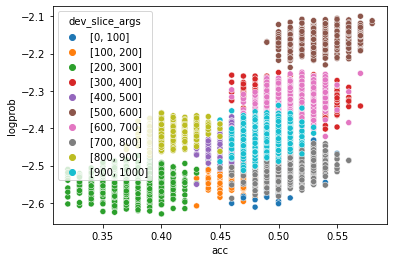

f1 corr 0.12172595929561408


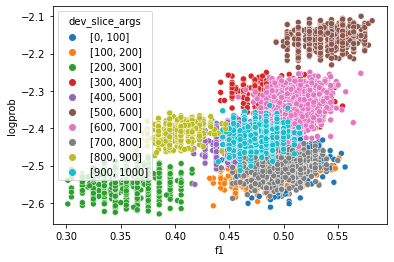

with prob
acc corr 0.1532198066126356


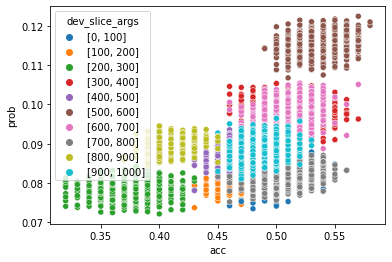

f1 corr 0.12116718655749521


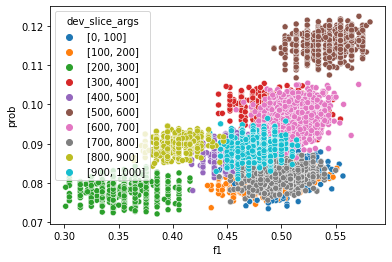

with normalized logprob
acc corr 0.27708041403167327


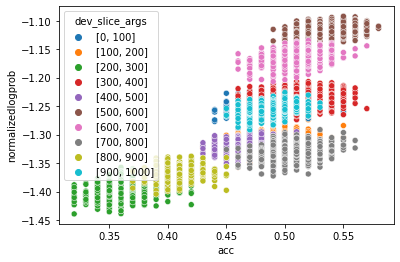

f1 corr 0.2628740267178192


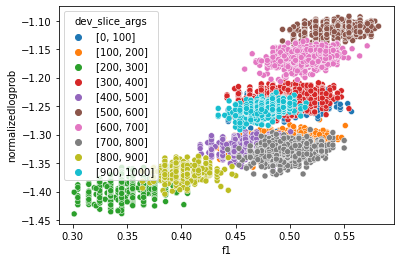

with normalized prob
acc corr 0.2771288299006485


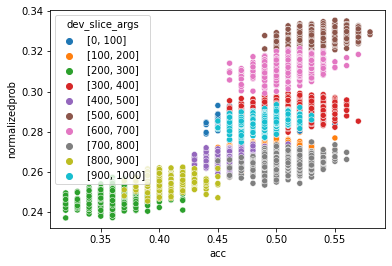

f1 corr 0.2629489237998184


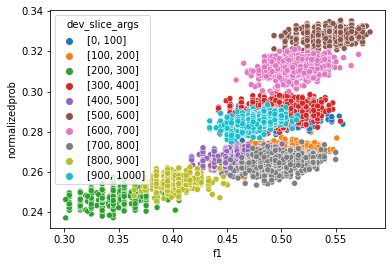

with acc
f1 corr 0.9851880218727087


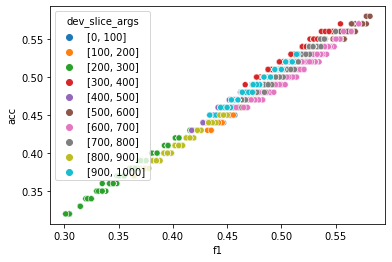

In [3]:
# Only makes sense if the val set is held static
df = get_full_df()
df = df[
    (df.checkpoint == 'checkpoints/metaicl/hr_to_lr/model.pt') &
    (df.task == 'commonsense_qa')
]
print(len(df))
print('with logprob')
print('acc corr', df.logprob_normalized.corr(df.acc_normalized))
sns.scatterplot(data=df, x='acc', y='logprob', hue='dev_slice_args')
plt.show()
print('f1 corr', df.logprob_normalized.corr(df.f1_normalized))
sns.scatterplot(data=df, x='f1', y='logprob', hue='dev_slice_args')
plt.show()
print('with prob')
print('acc corr', df.prob_normalized.corr(df.acc_normalized))
sns.scatterplot(data=df, x='acc', y='prob', hue='dev_slice_args')
plt.show()
print('f1 corr', df.prob_normalized.corr(df.f1_normalized))
sns.scatterplot(data=df, x='f1', y='prob', hue='dev_slice_args')
plt.show()
print('with normalized logprob')
print('acc corr', df.normalizedlogprob_normalized.corr(df.acc_normalized))
sns.scatterplot(data=df, x='acc', y='normalizedlogprob', hue='dev_slice_args')
plt.show()
print('f1 corr', df.normalizedlogprob_normalized.corr(df.f1_normalized))
sns.scatterplot(data=df, x='f1', y='normalizedlogprob', hue='dev_slice_args')
plt.show()
print('with normalized prob')
print('acc corr', df.normalizedprob_normalized.corr(df.acc_normalized))
sns.scatterplot(data=df, x='acc', y='normalizedprob', hue='dev_slice_args')
plt.show()
print('f1 corr', df.normalizedprob_normalized.corr(df.f1_normalized))
sns.scatterplot(data=df, x='f1', y='normalizedprob', hue='dev_slice_args')
plt.show()
print('with acc')
print('f1 corr', df.acc_normalized.corr(df.f1_normalized))
sns.scatterplot(data=df, x='f1', y='acc', hue='dev_slice_args')
plt.show()

In [4]:
def get_prompt(train_samples):
    train_samples = eval(train_samples)
    return '\n\n'.join(['input: %s\noutput: %s\n' % (dp['input'], dp['output']) for dp in train_samples])
class PromptPerformanceDataset(Dataset):
    def __init__(self, df, key):
        self.df = df
        self.key = key
    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
        row = self.df.iloc[index]
        return dict(
            prompt=get_prompt(row.train_samples),
            label=row[self.key],
        )
class PromptsPerformanceData(pl.LightningDataModule):
    def __init__(self, get_df_func, key='normalizedlogprob', train_percent=.8, val_percent=.1, seed=0, setting=None,
                 **dataloader_kwargs):
        super().__init__()
        self.get_df_func = get_df_func
        self.dataloader_kwargs = dataloader_kwargs
        self._train, self._val, self._test = None, None, None
        self.train_percent, self.val_percent, self.seed = train_percent, val_percent, seed
        self.setting = setting
        self.key = key
    def setup(self, stage=None):
        df = self.get_df_func()
        df = df[df.k != 0]
        if self.setting == 'no_example_overlap':
            self._train, self._val, self._test = [
                PromptPerformanceDataset(df[df['split'] == split], self.key)
                for split in ['train', 'val', 'test']]
        elif self.setting == 'no_dev_overlap':
#             df = df[df.train_data_split == 'train']
            df = df[df['split'] == 'train']
#             length = len(df)
            dev_slices = sorted(list(set(df.dev_slice_args)))
            length = len(dev_slices)
            train_length = round(length * self.train_percent)
            val_length = round(length * self.val_percent)
#             lengths = [train_length, val_length, length - train_length - val_length]
#             rows = [r for i, r in df.iterrows()]
#             splits = random_split(rows, lengths, generator=torch.Generator().manual_seed(self.seed))
#             self._train, self._val, self._test = [
#                 PromptPerformanceDataset(pd.DataFrame(list(x)), self.key) for x in splits]
            slice_sets = [
                dev_slices[:train_length],
                dev_slices[train_length:train_length + val_length],
                dev_slices[train_length + val_length:]]
            self._train, self._val, self._test = [
                PromptPerformanceDataset(df[df.apply(lambda r: r.dev_slice_args in slice_set, axis=1)], self.key)
                for slice_set in slice_sets]
        elif self.setting is None:
#             df = df[df.train_data_split == 'train']
            df = df[df['split'] == 'train']
            length = len(df)
            train_length = round(length * self.train_percent)
            val_length = round(length * self.val_percent)
            lengths = [train_length, val_length, length - train_length - val_length]
            rows = [r for i, r in df.iterrows()]
            splits = random_split(rows, lengths, generator=torch.Generator().manual_seed(self.seed))
            self._train, self._val, self._test = [
                PromptPerformanceDataset(pd.DataFrame(list(x)), self.key) for x in splits]
        else:
            raise NotImplementedError
    def train_dataloader(self):
        return DataLoader(self._train, **self.dataloader_kwargs, shuffle=True)
    def val_dataloader(self):
        return DataLoader(self._val, **self.dataloader_kwargs)
    def test_dataloader(self):
        return DataLoader(self._test, **self.dataloader_kwargs)

# Linear Regression on per-example Binary Variables

In [5]:
def get_features(indices):
    x = np.zeros(500)
    x[np.array(indices)] = 1
    return x
def getxy(df, key):
    X = np.stack(df.apply(lambda r: get_features(eval(r.train_indices)), axis=1))
    y = np.array(df[key])
    return X, y
def setup_and_train_linear_regression(task, checkpoint, key, save_coefs=False, setting=None):
    def get_df():
        df = get_full_df()
        return df[(df.task == task) & (df.checkpoint == checkpoint)]
    dm = PromptsPerformanceData(get_df, setting=setting)
    dm.setup()
    X_train, y_train = getxy(dm._train.df, key)
    print('train shapes: X - %s, y - %s' % (str(X_train.shape), str(y_train.shape)))
    X_val, y_val = getxy(dm._val.df, key)
    print('val shapes: X - %s, y - %s' % (str(X_val.shape), str(y_val.shape)))
    model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
#     print(model.summary())
#     model = LinearRegression()
#     model.fit(X_train, y_train)
    if save_coefs:
        if not os.path.exists('regcoef'):
            os.mkdir('regcoef')
        if not os.path.exists(os.path.join('regcoef', checkpoint.replace('/', '-'))):
            os.mkdir(os.path.join('regcoef', checkpoint.replace('/', '-')))
#         np.save(os.path.join('regcoef', checkpoint.replace('/', '-'), '%s.npy' % task), model.coef_)
        np.save(os.path.join('regcoef', checkpoint.replace('/', '-'), '%s.npy' % task), model.params[1:])
        if not os.path.exists('negregcoef'):
            os.mkdir('negregcoef')
        if not os.path.exists(os.path.join('negregcoef', checkpoint.replace('/', '-'))):
            os.mkdir(os.path.join('negregcoef', checkpoint.replace('/', '-')))
#         np.save(os.path.join('regcoef', checkpoint.replace('/', '-'), '%s.npy' % task), model.coef_)
        np.save(os.path.join('negregcoef', checkpoint.replace('/', '-'), '%s.npy' % task), -model.params[1:])
    return dm, model
def get_prediction_dfs_linear_regression(dm, model, key):
    X_train, y_train = getxy(dm._train.df, key)
#     y_train_pred = model.predict(X_train)
    y_train_pred = model.predict(sm.add_constant(X_train))
    train_df = dm._train.df.copy()
    train_df['regression_predictions'] = y_train_pred
    X_val, y_val = getxy(dm._val.df, key)
#     y_val_pred = model.predict(X_val)
    y_val_pred = model.predict(sm.add_constant(X_val))
    val_df = dm._val.df.copy()
    val_df['regression_predictions'] = y_val_pred
#     print('train regression score: %s, val regression score: %s' % (model.score(X_train, y_train), model.score(X_val, y_val)))
    return train_df, val_df

train shapes: X - (6400, 500), y - (6400,)
val shapes: X - (800, 500), y - (800,)
train corr: 0.293451, val corr: 0.035584


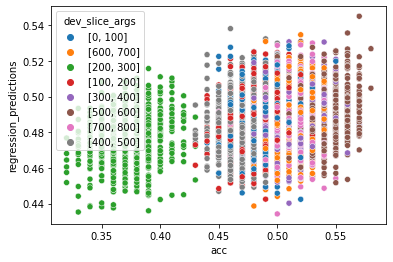

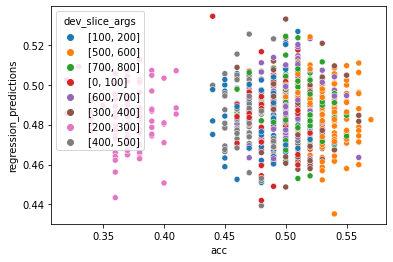

In [9]:
key = 'acc'
task = 'commonsense_qa'
dm, model = setup_and_train_linear_regression(
    task, 'checkpoints/metaicl/hr_to_lr/model.pt', key, save_coefs=True)
train_df, val_df = get_prediction_dfs_linear_regression(dm, model, key)
evaluate_prediction_dfs(train_df, val_df, key)

train shapes: X - (6400, 500), y - (6400,)
val shapes: X - (800, 500), y - (800,)
train corr: 0.357188, val corr: 0.125007


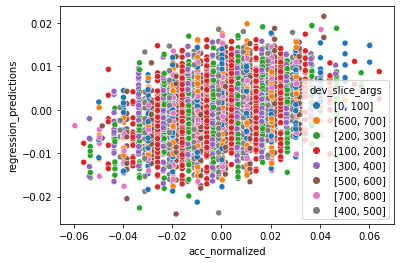

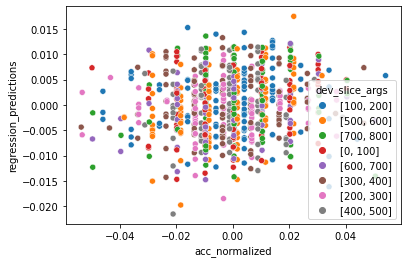

In [7]:
key = 'acc_normalized'
task = 'commonsense_qa'
dm, model = setup_and_train_linear_regression(
    task, 'checkpoints/metaicl/hr_to_lr/model.pt', key, save_coefs=True)
train_df, val_df = get_prediction_dfs_linear_regression(dm, model, key)
evaluate_prediction_dfs(train_df, val_df, key)

train shapes: X - (6000, 500), y - (6000,)
val shapes: X - (1000, 500), y - (1000,)
train corr: 0.531739, val corr: 0.329025


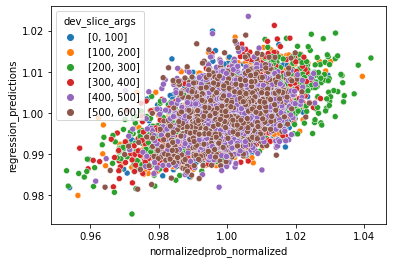

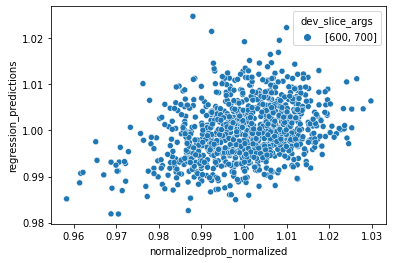

In [8]:
key = 'normalizedprob_normalized'
task = 'commonsense_qa'
# task = 'medical_questions_pairs'
dm, model = setup_and_train_linear_regression(
    task, 'checkpoints/metaicl/hr_to_lr/model.pt', key, save_coefs=True, setting='no_dev_overlap')
train_df, val_df = get_prediction_dfs_linear_regression(dm, model, key)
evaluate_prediction_dfs(train_df, val_df, key)

# Bert Regression

### Model

In [10]:
class StringRegressionModel(pl.LightningModule):
    def __init__(self, lr=1e-4):
        super().__init__()
        self.model = AutoModel.from_pretrained('roberta-base')
#         self.model = AutoModel.from_pretrained('roberta-large')
        self.model.parameters()
        self.linear = nn.Linear(768, 1)
#         self.linear = nn.Linear(1024, 1)
        self.loss = nn.MSELoss()
        self.lr = lr
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)
    def forward(self, batch):
        out = self.model(**batch['text'])
        predictions = self.linear(out[1]).squeeze(-1)
        return predictions
    def shared_step(self, batch, step_type):
        predictions = self(batch)
        loss = self.loss(predictions, batch['label'])
        self.log('loss/%s' % step_type, loss.item())
        return loss
    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, 'train')
    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, 'val')
    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, 'test')
    def predict_step(self, batch, batch_idx):
        return self(batch).cpu().numpy()
def part_requires_grad(m, rg):
    for p in m.parameters():
        p.requires_grad = rg
def freeze_roberta(model):
    part_requires_grad(model.embeddings, False)
    for i, m in enumerate(model.encoder.layer):
        if i < 6:
            part_requires_grad(m, False)
        else:
            part_requires_grad(m, True)
    part_requires_grad(model.pooler, True)
class CollateFn:
    def __init__(self):
        self.tokenizer = AutoTokenizer.from_pretrained('roberta-base')
    def __call__(self, instances):
        return dict(
            text=self.tokenizer([self.tokenizer.cls_token + ' ' + i['prompt'] for i in instances], return_tensors='pt', padding=True, truncation=True),
            label=torch.tensor([i['label'] for i in instances], dtype=torch.float32)
        )
def setup_and_train_roberta_regression(task, checkpoint, key, epochs=10, batch_size=32, lr=1e-4, seed=0, setting=None):
    def get_df():
        df = get_full_df()
        return df[(df.task == task) & (df.checkpoint == checkpoint)]
    dm = PromptsPerformanceData(get_df, key=key, batch_size=batch_size, collate_fn=CollateFn(), seed=seed,
                                setting=setting)
    dm.setup()
    model = StringRegressionModel(lr=lr)
    freeze_roberta(model.model)
    trainer = pl.Trainer(gpus=1, max_epochs=epochs, log_every_n_steps=10)
    trainer.fit(model, datamodule=dm)
    return trainer, dm, model
def get_prediction_dfs_roberta_regression(trainer, dm, model):
    train_reg_preds = np.concatenate(trainer.predict(model, dm.train_dataloader()))
    train_df = dm._train.df.copy()
    train_df['regression_predictions'] = train_reg_preds
    val_reg_preds = np.concatenate(trainer.predict(model, dm.val_dataloader()))
    val_df = dm._val.df.copy()
    val_df['regression_predictions'] = val_reg_preds
    return train_df, val_df

### Training and evaluating the model

In [15]:
# !kill 16416
%tensorboard --logdir=lightning_logs --port 6063

Reusing TensorBoard on port 6063 (pid 16772), started 2:04:32 ago. (Use '!kill 16772' to kill it.)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type         | Params
----------------------------------------
0 | model  | RobertaModel | 124 M

/home/mcinerney.de/.conda/envs/metaicl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/mcinerney.de/.conda/envs/metaicl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mcinerney.de/.conda/envs/metaicl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:495: PossibleUserWarning: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/home/mcinerney.de/.conda/envs/metaicl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mcinerney.de/.conda/envs/metaicl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



train corr: 0.010103, val corr: 0.052377


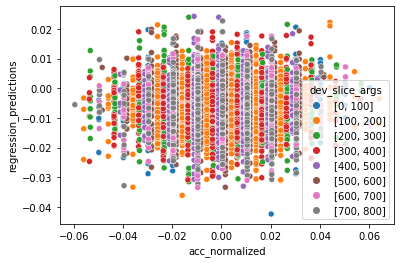

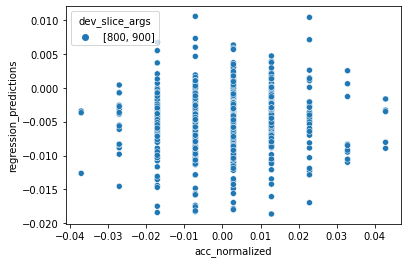

train corr: 0.012087, val corr: 0.051119


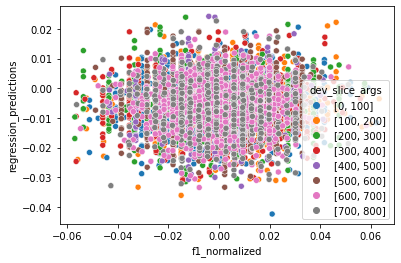

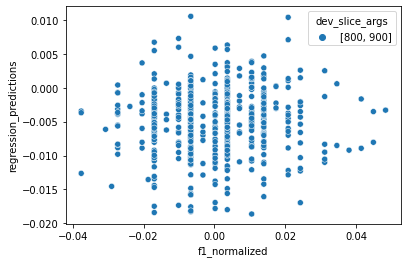

In [12]:
key = 'acc_normalized'
trainer, dm, model = setup_and_train_roberta_regression(
    'commonsense_qa', 'checkpoints/metaicl/hr_to_lr/model.pt', key, epochs=20, lr=1e-5, setting='no_example_overlap')
train_df, val_df = get_prediction_dfs_roberta_regression(trainer, dm, model)
evaluate_prediction_dfs(train_df, val_df, key)
evaluate_prediction_dfs(train_df, val_df, 'f1_normalized')

# Pairwise Ranking of Prompts

In [13]:
class PromptsPerformanceDataByTestSubset(PromptsPerformanceData):
    def setup(self, stage=None):
        super().setup(stage=stage)
        dev_slice_arg_set = set(self._train.df.dev_slice_args)
        self._train = [
            PromptPerformanceDataset(self._train.df[self._train.df.dev_slice_args == x], self.key)
            for x in dev_slice_arg_set]
        dev_slice_arg_set = set(self._val.df.dev_slice_args)
        self._val = [
            PromptPerformanceDataset(self._val.df[self._val.df.dev_slice_args == x], self.key)
            for x in dev_slice_arg_set]
        dev_slice_arg_set = set(self._test.df.dev_slice_args)
        self._test = [
            PromptPerformanceDataset(self._test.df[self._test.df.dev_slice_args == x], self.key)
            for x in dev_slice_arg_set]
    def train_dataloader(self):
        return [DataLoader(d, **self.dataloader_kwargs, shuffle=True) for d in self._train]
    def val_dataloader(self):
        return [DataLoader(d, **self.dataloader_kwargs) for d in self._val]
    def test_dataloader(self):
        return [DataLoader(d, **self.dataloader_kwargs) for d in self._test]
class StringPairRankingModel(pl.LightningModule):
    def __init__(self, lr=1e-4):
        super().__init__()
        self.model = AutoModel.from_pretrained('roberta-base')
#         self.model = AutoModel.from_pretrained('roberta-large')
        self.linear = nn.Linear(768, 768)
#         self.linear = nn.Linear(1024, 1024)
        self.activation = nn.ReLU()
#         self.loss = nn.MSELoss()
        self.lr = lr
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)
    def forward(self, batch):
        out = self.model(**batch['text'])
        vecs1 = self.activation(self.linear(out[1]))
        vecs2 = out[1]
        return vecs1, vecs2
    def shared_step(self, batch, step_type):
        batches = [batch] if not isinstance(batch, list) else batch
        lengths, input_ids, attention_mask = [], [], []
        for batch in batches:
            input_ids.append(batch['text']['input_ids'])
            attention_mask.append(batch['text']['attention_mask'])
            lengths.append(batch['text']['input_ids'].shape[0])
        input_ids = pad_and_concat(input_ids)
        input_ids = input_ids.reshape(-1, *input_ids.shape[2:])
        attention_mask = pad_and_concat(attention_mask)
        attention_mask = attention_mask.reshape(-1, *attention_mask.shape[2:])
        allvecs1, allvecs2 = self({'text': {'input_ids': input_ids, 'attention_mask': attention_mask}})
        losses = []
        accs = []
#         for batch in batches:
#             vecs1, vecs2 = self(batch)
        offset = 0
        for length in lengths:
            vecs1, vecs2 = allvecs1[offset:offset+length], allvecs2[offset:offset+length]
            offset += length
            predictions = torch.mm(vecs1, vecs2.transpose(0, 1))
            predictions = torch.sigmoid(predictions)
    #         loss = -(predictions * batch['label']).sum()
            loss = - torch.log(predictions[batch['label'] == 1]).sum() - torch.log(1 - predictions[batch['label'] == -1]).sum()
    #         loss = torch.log(1 - predictions[batch['label'] == 1]).sum() + torch.log(predictions[batch['label'] == -1]).sum()
#             self.log('loss/%s' % step_type, loss.item())
            losses.append(loss)
            acc = (((predictions > .5) * 2 - 1) == batch['label']).sum() / (batch['label'] != 0).sum()
#             self.log('acc/%s' % step_type, acc.item())
            accs.append(acc)
#             return loss
        losses = torch.stack(losses)
        accs = torch.stack(accs)
        self.log('loss/%s' % step_type, losses.mean().item())
        self.log('acc/%s' % step_type, accs.mean().item())
        return losses.mean()
    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, 'train')
    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, 'val')
    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, 'test')
    def predict_step(self, batch, batch_idx):
        vecs1, vecs2 = self(batch)
        return vecs1.cpu().numpy(), vecs2.cpu().numpy()
class PairRankingCollateFn:
    def __init__(self):
        self.tokenizer = AutoTokenizer.from_pretrained('roberta-base')
    def __call__(self, instances):
        batch = dict(
            text=self.tokenizer([self.tokenizer.cls_token + ' ' + i['prompt'] for i in instances], return_tensors='pt', padding=True, truncation=True),
        )
        if 'label' in instances[0].keys():
            labels = []
            for i, i1 in enumerate(instances):
                labels.append([])
                for j, i2 in enumerate(instances):
                    labels[-1].append(0 if i == j or i1['label'] == i2['label'] else 1 if i1['label'] > i2['label'] else -1)
            batch['label'] = torch.tensor(labels, dtype=torch.float32)
        return batch
def setup_and_train_roberta_pair_ranking(task, checkpoint, key, epochs=10, batch_size=8, lr=1e-5, seed=0, setting=None):
    def get_df():
        df = get_full_df()
        return df[(df.task == task) & (df.checkpoint == checkpoint)]
#     dm = PromptsPerformanceData(get_df, key=key, batch_size=batch_size, collate_fn=PairRankingCollateFn(),
#                                 seed=seed,
#                                 setting=setting)
    dm = PromptsPerformanceDataByTestSubset(
        get_df, key=key, batch_size=batch_size, collate_fn=PairRankingCollateFn(),
        seed=seed,
        setting=setting)
    dm.setup()
    model = StringPairRankingModel(lr=lr)
    freeze_roberta(model.model)
    trainer = pl.Trainer(gpus=1, max_epochs=epochs, log_every_n_steps=10)
    trainer.fit(model, datamodule=dm)
    return trainer, dm, model
class RowKey:
    def __init__(self, vec1, vec2, pbar):
        self.vec1 = vec1
        self.vec2 = vec2
        self.pbar = pbar
    def get_comparison_score(self, other):
        x = (self.vec1[None, :] @ other.vec2[:, None])[0, 0]
        x = 1/(1 + np.exp(-x))
        self.pbar.update(1)
        return x
    def __gt__(self, other):
        return self.get_comparison_score(other) > .5
    def __lt__(self, other):
        return not (self > other)
    def __ge__(self, other):
        return self > other
    def __le__(self, other):
        return self < other
def evaluate_roberta_pair_ranking(trainer, dm, model, key, split='val'):
    if split == 'val':
        allrows = [dataset.df.copy() for dataset in dm._val]
        alldls = dm.val_dataloader()
    elif split == 'train':
        allrows = [dataset.df.copy() for dataset in dm._train]
        alldls = dm.train_dataloader()
    else:
        raise NotImplementedError
    for rows, dl in zip(allrows, alldls):
        print('sorting %i rows' % len(rows))
        with torch.no_grad():
            predictions = trainer.predict(model, dl)
            predictions = [(vec1, vec2) for vecs1, vecs2 in predictions for vec1, vec2 in zip(vecs1, vecs2)]
            with tqdm() as pbar:
                original_spots = [
                    x[0] for x in sorted(
                        [(i, vec1, vec2)
                         for i, (vec1, vec2) in enumerate(predictions)],
                        key=lambda x: RowKey(x[1], x[2], pbar))
                ]
        rankings = [-1] * len(rows)
        for i, original_spot in enumerate(original_spots):
            rankings[original_spot] = i
        rows['regression_predictions'] = rankings
    return pd.concat(allrows)

In [14]:
key = 'acc_normalized'
trainer, dm, model = setup_and_train_roberta_pair_ranking(
    'commonsense_qa', 'checkpoints/metaicl/hr_to_lr/model.pt', key, epochs=20, lr=1e-5, setting='no_example_overlap')
val_df = evaluate_roberta_pair_ranking(trainer, dm, model, key, split='val')
train_df = evaluate_roberta_pair_ranking(trainer, dm, model, key, split='train')
evaluate_prediction_dfs(train_df, val_df, key)
evaluate_prediction_dfs(train_df, val_df, 'f1_normalized')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type         | Params
--------------------------------------------
0 | model      | RobertaM

/home/mcinerney.de/.conda/envs/metaicl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/mcinerney.de/.conda/envs/metaicl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



train corr: -0.003235, val corr: 0.102341


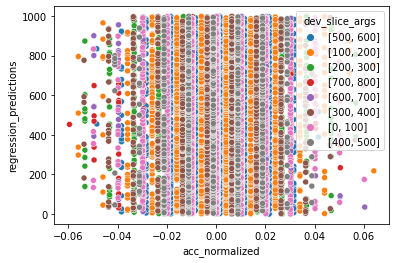

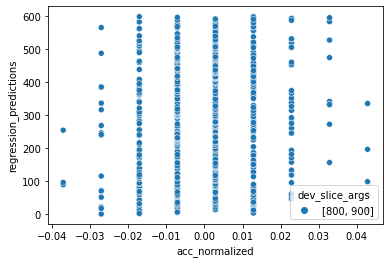

train corr: -0.002162, val corr: 0.093614


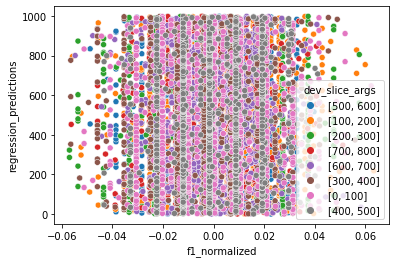

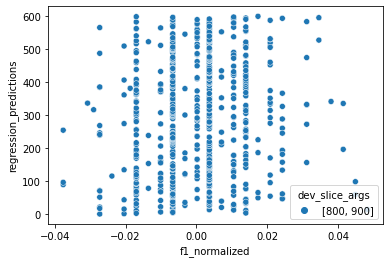

In [16]:
evaluate_prediction_dfs(train_df, val_df, key)
evaluate_prediction_dfs(train_df, val_df, 'f1_normalized')

# Per-example Correlation Coefficient Regression

For a given example, can we estimate how the correlation coefficient between including the example in the prompt and the score? If so, we would be able to estimate which examples are more positively correlated and use them in the prompt.

In [ ]:
key = 'normalizedprob_normalized'
dm, model = setup_and_train_linear_regression('commonsense_qa', 'checkpoints/metaicl/hr_to_lr/model.pt', key)
print(model.params)

In [ ]:
key = 'normalizedprob_normalized'
dm, model = setup_and_train_linear_regression('commonsense_qa', 'checkpoints/metaicl/hr_to_lr/model.pt', key)
plt.hist(model.params[1:])
df = get_full_df()
df = df[(df.task == 'commonsense_qa') & (df.checkpoint == 'checkpoints/metaicl/hr_to_lr/model.pt')]
examples_df = {}
for i, row in df.iterrows():
    for index, example in zip(eval(row.train_indices), eval(row.train_samples)):
        example['coefficient'] = model.params[index + 1]
        examples_df[index] = example
examples_df = pd.DataFrame(examples_df).transpose()
examples_df

### Data